# Progression
- attempting to patch over the entire epithelium
- get variance and average of dimensions across patchs and within one patch for 6 patients (6 was enough to see that one patch size would not work)

### Notes
- only used "normal" tissues, only H&E since those are extracted well by Prashant
- previous rectangular patches required too many conditional stipulations, went to square  as lit review team also spoke about wanting to use

In [1]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Importing Epithelium Extractions (Ran Prashant's Algo Separately)

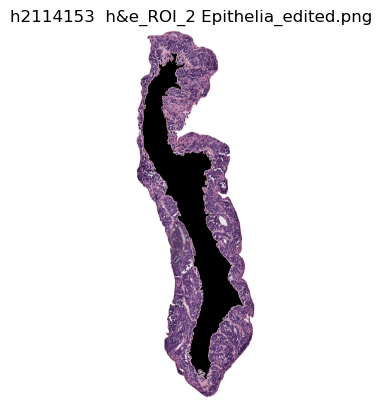

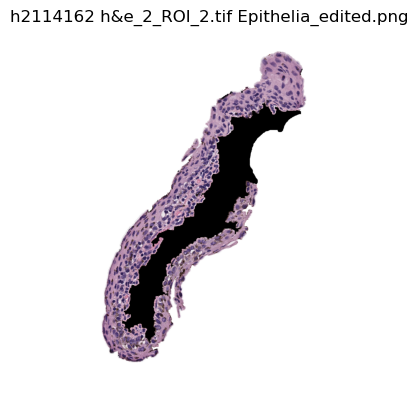

In [2]:
## import + display extractions

import os

folder_path = 'D:\\390scans\\background_white\\'

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.tif'):
        # Construct full file path
        file_path = os.path.join(folder_path, filename)
        
        # Load and display the image
        img = mpimg.imread(file_path)
        
        # Check if the image has an alpha channel and remove it if necessary
        if img.shape[2] == 4:
            img = img[:, :, :3]
        
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.title(filename)  # Show the filename as the title
        plt.show()


# Generating Square patches
- clear and easy on the eyes, melanocyte density is valid (concern brought up during last stakeholder meeting)

Random points coordinates: [(716, 927), (378, 1370), (1432, 422), (1227, 588), (383, 1341), (477, 1105)]


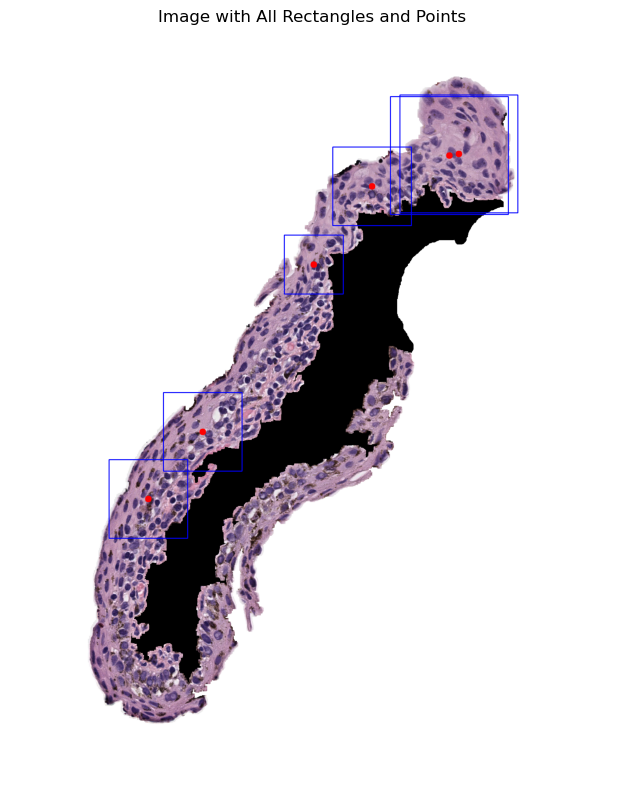

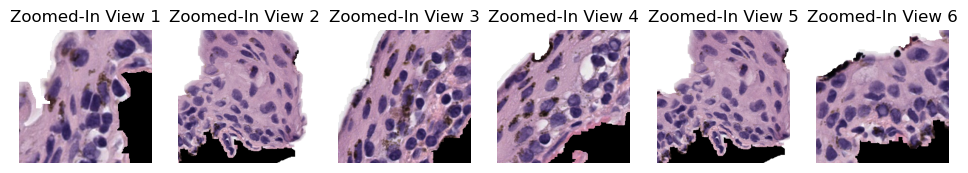

Rectangle 1 dimensions: Width = 180 pixels, Height = 180 pixels
Rectangle 2 dimensions: Width = 360 pixels, Height = 360 pixels
Rectangle 3 dimensions: Width = 240 pixels, Height = 240 pixels
Rectangle 4 dimensions: Width = 240 pixels, Height = 240 pixels
Rectangle 5 dimensions: Width = 360 pixels, Height = 360 pixels
Rectangle 6 dimensions: Width = 240 pixels, Height = 240 pixels


In [23]:
import cv2
import numpy as np
import random

#image_path = 'D:\\390scans\\background_white\\h2114153  h&e_ROI_2 Epithelia_edited.png' 
image_path = 'D:\\390scans\\background_white\\h2114162 h&e_2_ROI_2.tif Epithelia_edited.png' 
#image_path = 'D:\\390scans\\black_stroma\\\stroma5.png'
image = cv2.imread(image_path)

def contains_black_white_mask(region):
    contains_black = np.any(np.all(region == [0, 0, 0], axis=-1))
    contains_white = np.any(np.all(region == [255, 255, 255], axis=-1))
    contains_mask = np.any((region != [0, 0, 0]).all(axis=-1) & (region != [255, 255, 255]).all(axis=-1))
    return contains_black and contains_white and contains_mask

# Mask for black areas
black_mask = cv2.inRange(image, np.array([0, 0, 0]), np.array([0, 0, 0]))

# Mask for white areas
white_mask = cv2.inRange(image, np.array([255, 255, 255]), np.array([255, 255, 255]))

# Mask for non-black and non-white pixels
non_black_white_mask = cv2.inRange(image, np.array([1, 1, 1]), np.array([254, 254, 254]))

# Calculate distance to the nearest black and white pixels
black_distance = cv2.distanceTransform(255 - black_mask, cv2.DIST_L2, 3)
white_distance = cv2.distanceTransform(255 - white_mask, cv2.DIST_L2, 3)

# Find coordinates of non-black and non-white pixels
coordinates = np.column_stack(np.where(non_black_white_mask > 0))

# Define the ratio tolerance range
min_ratio, max_ratio = 0.7, 1.3

# Filter coordinates based on the ratio of distances to black and white areas
balanced_points = [
    coord for coord in coordinates
    if min_ratio <= (black_distance[coord[0], coord[1]] / white_distance[coord[0], coord[1]]) <= max_ratio
]

# Select random points from these balanced points
random_points = [random.choice(balanced_points) for _ in range(6)]
print(f"Random points coordinates: {[(p[0], p[1]) for p in random_points]}")

# Copy the original image to draw rectangles for each random point
image_with_rectangles = image.copy()
zoomed_in_regions = []
rect_dimensions = []

# Parameters for square size
initial_size = 30

# Process each random point
for random_point in random_points:
    center_x, center_y = int(random_point[1]), int(random_point[0])
    num_squares_drawn = 0
    vertical_preference = False  # Flag to switch to vertical rectangle if needed

    # Expansion phase
    while True:
        # Calculate the current square's size
        size = initial_size * (num_squares_drawn + 1)
        
        # Calculate the top-left and bottom-right coordinates of the square
        top = center_y - size
        bottom = center_y + size
        left = center_x - size
        right = center_x + size

        # Define regions at each corner of the square
        corner_checks = {
            "top_left": (top, left),
            "top_right": (top, right - initial_size),
            "bottom_left": (bottom - initial_size, left),
            "bottom_right": (bottom - initial_size, right - initial_size)
        }

        # Track how many corners are outside the mask
        corners_outside_count = 0

        # Check each corner and determine if it is outside the mask
        for corner_name, (corner_y, corner_x) in corner_checks.items():
            # Ensure the region is within the image bounds
            if corner_y < 0 or corner_x < 0 or corner_y + initial_size > image.shape[0] or corner_x + initial_size > image.shape[1]:
                corners_outside_count += 1
                continue

            # Extract the corner region in the mask at this corner
            corner_region = non_black_white_mask[corner_y:corner_y + initial_size, corner_x:corner_x + initial_size]
            
            # Check if more than 75% of pixels in the corner region are outside the mask
            pixels_outside_mask = np.count_nonzero(corner_region == 0)
            total_pixels = corner_region.size
            percentage_outside = pixels_outside_mask / total_pixels

            # If 75% or more pixels are outside the mask, count this corner
            if percentage_outside >= 0.75:
                corners_outside_count += 1

            # Stop checking if we already have two corners outside
            if corners_outside_count >= 2:
                break

        # Stop drawing squares if at least two corners have 75% or more pixels outside the mask
        if corners_outside_count >= 2:
            # Check if the region shape requires a vertical rectangle
            if (bottom - top) > (right - left) * 1.5:  # If height is significantly larger than width
                vertical_preference = True
            break  # Stop expanding the square

        # Increment the number of squares drawn
        num_squares_drawn += 1

    # Shrinking phase with iteration limit
    max_shrink_iterations = 100  # Limit to avoid infinite loop
    iterations = 0

    while (can_shrink_top or can_shrink_bottom or can_shrink_left or can_shrink_right) and iterations < max_shrink_iterations:
        if can_shrink_top and top < center_y and top < bottom - 1:
            top += 1
            if not contains_black_white_mask(image[top:bottom, left:right]):
                top -= 1
                can_shrink_top = False
        if can_shrink_bottom and bottom > center_y and bottom > top + 1:
            bottom -= 1
            if not contains_black_white_mask(image[top:bottom, left:right]):
                bottom += 1
                can_shrink_bottom = False
        if can_shrink_left and left < center_x and left < right - 1:
            left += 1
            if not contains_black_white_mask(image[top:bottom, left:right]):
                left -= 1
                can_shrink_left = False
        if can_shrink_right and right > center_x and right > left + 1:
            right -= 1
            if not contains_black_white_mask(image[top:bottom, left:right]):
                right += 1
                can_shrink_right = False

        # Increment iteration count to prevent infinite loop
        iterations += 1

    if iterations >= max_shrink_iterations:
        print("Reached maximum shrink iterations, stopping shrinking to prevent infinite loop.")

    # Adjust rectangle dimensions based on vertical preference
    if vertical_preference:
        width = initial_size
        height = bottom - top
        left = center_x - width // 2
        right = center_x + width // 2
        cv2.rectangle(image_with_rectangles, (left, top), (right, bottom), (0, 255, 0), 2)  # Draw vertical rectangle in green
    else:
        cv2.rectangle(image_with_rectangles, (left, top), (right, bottom), (255, 0, 0), 2)  # Draw square in blue

    # Draw the center point for reference
    cv2.circle(image_with_rectangles, (center_x, center_y), radius=10, color=(0, 0, 255), thickness=-1)

    # Store dimensions for each rectangle
    rect_dimensions.append((right - left, bottom - top))
    zoomed_in_regions.append(image[top:bottom, left:right])
    
# Display the original image with all rectangles
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.title("Image with All Rectangles and Points")
plt.imshow(cv2.cvtColor(image_with_rectangles, cv2.COLOR_BGR2RGB))
plt.axis("off")

# Display zoomed-in regions
plt.figure(figsize=(12, 6))
for i, region in enumerate(zoomed_in_regions, 1):
    plt.subplot(1, 6, i)
    plt.title(f"Zoomed-In View {i}")
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.show()

# Print dimensions of each final rectangle
for i, (width, height) in enumerate(rect_dimensions, 1):
    print(f"Rectangle {i} dimensions: Width = {width} pixels, Height = {height} pixels")


# Attempt to patch over entire epithelium

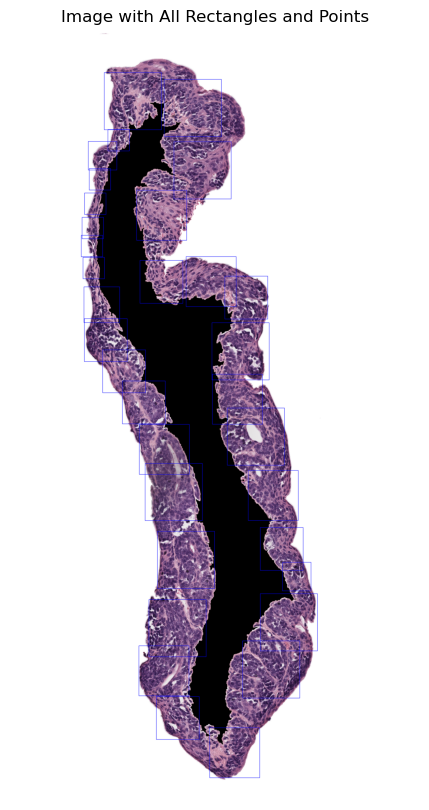

Rectangle 1 dimensions: Length = 360 pixels, Width = 360 pixels
Rectangle 2 dimensions: Length = 480 pixels, Width = 480 pixels
Rectangle 3 dimensions: Length = 420 pixels, Width = 420 pixels
Rectangle 4 dimensions: Length = 480 pixels, Width = 480 pixels
Rectangle 5 dimensions: Length = 420 pixels, Width = 420 pixels
Rectangle 6 dimensions: Length = 360 pixels, Width = 360 pixels
Rectangle 7 dimensions: Length = 480 pixels, Width = 480 pixels
Rectangle 8 dimensions: Length = 420 pixels, Width = 420 pixels
Rectangle 9 dimensions: Length = 420 pixels, Width = 420 pixels
Rectangle 10 dimensions: Length = 360 pixels, Width = 360 pixels
Rectangle 11 dimensions: Length = 480 pixels, Width = 480 pixels
Rectangle 12 dimensions: Length = 480 pixels, Width = 480 pixels
Rectangle 13 dimensions: Length = 420 pixels, Width = 420 pixels
Rectangle 14 dimensions: Length = 480 pixels, Width = 480 pixels
Rectangle 15 dimensions: Length = 480 pixels, Width = 480 pixels
Rectangle 16 dimensions: Length = 

In [38]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# Load the image
image_path = 'D:\\390scans\\background_white\\h2114153  h&e_ROI_2 Epithelia_edited.png' 
#image_path = 'D:\\390scans\\black_stroma\\\stroma5.png'
image = cv2.imread(image_path)

# Function to check if a region contains black, white, and non-black-white mask
def contains_black_white_mask(region):
    contains_black = np.any(np.all(region == [0, 0, 0], axis=-1))
    contains_white = np.any(np.all(region == [255, 255, 255], axis=-1))
    contains_mask = np.any((region != [0, 0, 0]).all(axis=-1) & (region != [255, 255, 255]).all(axis=-1))
    return contains_black and contains_white and contains_mask

# Mask for black areas, white areas, and non-black-white pixels
black_mask = cv2.inRange(image, np.array([0, 0, 0]), np.array([0, 0, 0]))
white_mask = cv2.inRange(image, np.array([255, 255, 255]), np.array([255, 255, 255]))
non_black_white_mask = cv2.inRange(image, np.array([1, 1, 1]), np.array([254, 254, 254]))

# Calculate distance to the nearest black and white pixels
black_distance = cv2.distanceTransform(255 - black_mask, cv2.DIST_L2, 3)
white_distance = cv2.distanceTransform(255 - white_mask, cv2.DIST_L2, 3)

# Find coordinates of non-black and non-white pixels
coordinates = np.column_stack(np.where(non_black_white_mask > 0))

# Define the ratio tolerance range for balanced points
min_ratio, max_ratio = 0.7, 1.3

# Filter coordinates to only include balanced points
balanced_points = [
    coord for coord in coordinates
    if min_ratio <= (black_distance[coord[0], coord[1]] / white_distance[coord[0], coord[1]]) <= max_ratio
]

# Define max attempts and initial size parameters
max_attempts = 500
initial_size = 30
covered_coordinates = set()
rectangles = []
attempts = 0

# Function to calculate overlap
def calculate_overlap(new_coords, existing_coords):
    overlap = len(new_coords.intersection(existing_coords)) / len(new_coords)
    return overlap

# Start generating squares using only balanced points as starting locations
while len(balanced_points) > 0 and attempts < max_attempts:
    attempts += 1
    # Randomly select a new center point for the square from balanced points
    random_coord = random.choice(balanced_points)
    center_x, center_y = int(random_coord[1]), int(random_coord[0])
    num_squares_drawn = 0
    vertical_preference = False

    # Expansion phase for square
    while True:
        size = initial_size * (num_squares_drawn + 1)
        top, bottom = center_y - size, center_y + size
        left, right = center_x - size, center_x + size

        # Define regions at each corner of the square
        corner_checks = {
            "top_left": (top, left),
            "top_right": (top, right - initial_size),
            "bottom_left": (bottom - initial_size, left),
            "bottom_right": (bottom - initial_size, right - initial_size)
        }

        # Track how many corners are outside the mask
        corners_outside_count = 0

        # Check each corner and determine if it is outside the mask
        for corner_name, (corner_y, corner_x) in corner_checks.items():
            # Ensure the region is within the image bounds
            if corner_y < 0 or corner_x < 0 or corner_y + initial_size > image.shape[0] or corner_x + initial_size > image.shape[1]:
                corners_outside_count += 1
                continue

            # Extract the corner region in the mask at this corner
            corner_region = non_black_white_mask[corner_y:corner_y + initial_size, corner_x:corner_x + initial_size]
            
            # If all pixels in the corner region are black, mark this corner as outside the mask
            if not np.any(corner_region):
                corners_outside_count += 1

            # Stop checking if we already have two corners outside
            if corners_outside_count >= 2:
                break

        # Stop expanding if at least two corners are outside the mask
        if corners_outside_count >= 2:
            # Check if the region shape requires a vertical rectangle
            if (bottom - top) > (right - left) * 1.5:
                vertical_preference = True
            break  # Stop expanding as it satisfies the mask requirements

        # Increment the number of squares drawn to expand further
        num_squares_drawn += 1
        if num_squares_drawn > 7:  # Limit expansion if square becomes too large
            break

    # Get all coordinates in the current square
    new_square_coords = set((y, x) for y in range(max(0, top), min(image.shape[0], bottom))
                                    for x in range(max(0, left), min(image.shape[1], right)))

    # Check overlap with existing covered coordinates
    if calculate_overlap(new_square_coords, covered_coordinates) <= 0.2:
        covered_coordinates.update(new_square_coords)
        rectangles.append((left, top, right, bottom))
        
        # Draw the rectangle
        color = (0, 255, 0) if vertical_preference else (255, 0, 0)
        cv2.rectangle(image, (left, top), (right, bottom), color, 2)

        # Remove these coordinates from the non-black-white mask list and balanced points
        coordinates = np.array([coord for coord in coordinates if tuple(coord) not in new_square_coords])
        balanced_points = [coord for coord in balanced_points if tuple(coord) not in new_square_coords]

# Display the resulting image with all rectangles
plt.figure(figsize=(10, 10))
plt.title("Image with All Rectangles and Points")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Print dimensions of each final rectangle as Length x Width
for i, (left, top, right, bottom) in enumerate(rectangles, 1):
    length = bottom - top  # Height of the rectangle
    width = right - left   # Width of the rectangle
    print(f"Rectangle {i} dimensions: Length = {length} pixels, Width = {width} pixels")

output_path = 'D:\\390scans\\patches\\patched_image2.png' 
cv2.imwrite(output_path, image)
print(f"Image saved to {output_path}")

# automation across folder of images

In [39]:
import cv2
import numpy as np
import random
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define paths for input folder and output folder
input_folder = 'D:\\390scans\\background_white\\'  # Folder containing images
output_folder = 'D:\\390scans\\patches\\'  # Folder to save results

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# DataFrame to store metrics for each image
image_metrics = []

# Variables to track overall statistics across all images
all_lengths = []
all_widths = []

# Process each image in the input folder
for image_file in os.listdir(input_folder):
    if image_file.endswith(('.png', '.jpg', '.jpeg', '.tif')):  # Check for image files
        # Load the image
        image_path = os.path.join(input_folder, image_file)
        image = cv2.imread(image_path)
        if image is None:
            continue  # Skip if the image cannot be loaded

        # Mask and distance calculations
        black_mask = cv2.inRange(image, np.array([0, 0, 0]), np.array([0, 0, 0]))
        white_mask = cv2.inRange(image, np.array([255, 255, 255]), np.array([255, 255, 255]))
        non_black_white_mask = cv2.inRange(image, np.array([1, 1, 1]), np.array([254, 254, 254]))
        black_distance = cv2.distanceTransform(255 - black_mask, cv2.DIST_L2, 3)
        white_distance = cv2.distanceTransform(255 - white_mask, cv2.DIST_L2, 3)

        # Find coordinates of non-black and non-white pixels
        coordinates = np.column_stack(np.where(non_black_white_mask > 0))

        # Define the ratio tolerance range for balanced points
        min_ratio, max_ratio = 0.7, 1.3

        # Filter coordinates to only include balanced points
        balanced_points = [
            coord for coord in coordinates
            if min_ratio <= (black_distance[coord[0], coord[1]] / white_distance[coord[0], coord[1]]) <= max_ratio
        ]

        # Parameters for rectangle generation
        max_attempts = 500
        initial_size = 30
        covered_coordinates = set()
        rectangles = []
        attempts = 0

        # Start generating squares for the current image
        while len(balanced_points) > 0 and attempts < max_attempts:
            attempts += 1
            random_coord = random.choice(balanced_points)
            center_x, center_y = int(random_coord[1]), int(random_coord[0])
            num_squares_drawn = 0
            vertical_preference = False

            # Expansion phase for square
            while True:
                size = initial_size * (num_squares_drawn + 1)
                top, bottom = center_y - size, center_y + size
                left, right = center_x - size, center_x + size

                # Define regions at each corner of the square
                corner_checks = {
                    "top_left": (top, left),
                    "top_right": (top, right - initial_size),
                    "bottom_left": (bottom - initial_size, left),
                    "bottom_right": (bottom - initial_size, right - initial_size)
                }

                # Track how many corners are outside the mask
                corners_outside_count = 0

                # Check each corner and determine if it is outside the mask
                for corner_name, (corner_y, corner_x) in corner_checks.items():
                    if corner_y < 0 or corner_x < 0 or corner_y + initial_size > image.shape[0] or corner_x + initial_size > image.shape[1]:
                        corners_outside_count += 1
                        continue
                    corner_region = non_black_white_mask[corner_y:corner_y + initial_size, corner_x:corner_x + initial_size]
                    if not np.any(corner_region):
                        corners_outside_count += 1
                    if corners_outside_count >= 2:
                        break

                # Stop expanding if at least two corners are outside the mask
                if corners_outside_count >= 2:
                    if (bottom - top) > (right - left) * 1.5:
                        vertical_preference = True
                    break

                num_squares_drawn += 1
                if num_squares_drawn > 7:
                    break

            new_square_coords = set((y, x) for y in range(max(0, top), min(image.shape[0], bottom))
                                            for x in range(max(0, left), min(image.shape[1], right)))

            # Check overlap with existing covered coordinates
            if calculate_overlap(new_square_coords, covered_coordinates) <= 0.2:
                covered_coordinates.update(new_square_coords)
                rectangles.append((left, top, right, bottom))
                color = (0, 255, 0) if vertical_preference else (255, 0, 0)
                cv2.rectangle(image, (left, top), (right, bottom), color, 2)
                coordinates = np.array([coord for coord in coordinates if tuple(coord) not in new_square_coords])
                balanced_points = [coord for coord in balanced_points if tuple(coord) not in new_square_coords]

        # Calculate statistics for this image
        lengths = [bottom - top for left, top, right, bottom in rectangles]
        widths = [right - left for left, top, right, bottom in rectangles]
        num_rectangles = len(rectangles)
        avg_width = np.mean(widths) if widths else 0
        variance_dimensions = np.var(lengths + widths) if lengths and widths else 0

        # Add to the overall list of dimensions
        all_lengths.extend(lengths)
        all_widths.extend(widths)

        # Append results to the DataFrame list
        image_metrics.append({
            'Image': image_file,
            'Num Rectangles': num_rectangles,
            'Avg Width': avg_width,
            'Variance Dimensions': variance_dimensions
        })

        # Save the processed image with rectangles
        output_image_path = os.path.join(output_folder, f"patched_{image_file}")
        cv2.imwrite(output_image_path, image)
        print(f"Processed and saved: {output_image_path}")

# Create DataFrame from the metrics list
df = pd.DataFrame(image_metrics)

# Display overall statistics across all images
overall_lengths = all_lengths
overall_widths = all_widths
overall_dimensions = overall_lengths + overall_widths
overall_avg_dimension = np.mean(overall_dimensions)
overall_variance_dimension = np.var(overall_dimensions)
smallest_square = min(overall_dimensions)
largest_square = max(overall_dimensions)

print("\nOverall Statistics Across All Images:")
print(f"Smallest Square Dimension: {smallest_square} pixels")
print(f"Largest Square Dimension: {largest_square} pixels")
print(f"Variance in Dimensions: {overall_variance_dimension}")
print(f"Average Dimension: {overall_avg_dimension}")

# Display the DataFrame to the user
df


Processed and saved: D:\390scans\patches\patched_h2114153  h&e_ROI_2 Epithelia_edited.png
Processed and saved: D:\390scans\patches\patched_h2114161 h&e_ROI_1.tif Epithelia.png
Processed and saved: D:\390scans\patches\patched_h2114162 h&e_2_ROI_2.tif Epithelia_edited.png
Processed and saved: D:\390scans\patches\patched_h2114168 h&e_ROI_1.tif Epithelia.png
Processed and saved: D:\390scans\patches\patched_h2114168 h&e_ROI_12.tif Epithelia.png
Processed and saved: D:\390scans\patches\patched_h2114168 h&e_ROI_12_1.tif Epithelia.png

Overall Statistics Across All Images:
Smallest Square Dimension: 120 pixels
Largest Square Dimension: 480 pixels
Variance in Dimensions: 10644.897959183674
Average Dimension: 285.7142857142857


,Image,Num Rectangles,Avg Width,Variance Dimensions
0,h2114153 h&e_ROI_2 Epithelia_edited.png,34,354.705882,13207.266436
1,h2114161 h&e_ROI_1.tif Epithelia.png,35,217.714286,5983.346939
2,h2114162 h&e_2_ROI_2.tif Epithelia_edited.png,15,232.000000,1856.000000
3,h2114168 h&e_ROI_1.tif Epithelia.png,20,276.000000,12744.000000
4,h2114168 h&e_ROI_12.tif Epithelia.png,27,311.111111,5343.209877
5,h2114168 h&e_ROI_12_1.tif Epithelia.png,16,307.500000,5343.750000
